In [1]:
print("Howdy")

Howdy


In [59]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
from diffusers.utils import load_image
#from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor

# switch to "mps" for apple devices
#pipe = DiffusionPipeline.from_pretrained("lambdalabs/sd-image-variations-diffusers", dtype=torch.bfloat16, device_map="cuda")
#pipe = StableDiffusionImageVariationPipeline.from_pretrained("/home/kojo/Code/sd-image-variations-diffusers/", local_files_only=True)
pipe = StableDiffusionImg2ImgPipeline.from_single_file("/home/kojo/Code/stable-diffusion-v1-5/v1-5-pruned-emaonly.safetensors")
pipe.feature_extractor = None

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [60]:
pipe

StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.36.0",
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
pipe.load_ip_adapter("/home/kojo/Code/IP-Adapter/", subfolder="models", weight_name="ip-adapter-plus_sd15.safetensors", image_encoder_folder="image_encoder", local_files_only=True)

In [62]:
pipe

StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.36.0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    "transformers",
    "CLIPVisionModelWithProjection"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [63]:
from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor

image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "/home/kojo/Code/IP-Adapter/", 
    subfolder="models/image_encoder", 
    local_files_only=True
)

feature_extractor = CLIPImageProcessor.from_pretrained(
    "/home/kojo/Code/IP-Adapter/", 
    subfolder="models/image_encoder",
    local_files_only=True
)

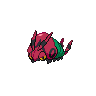

In [74]:
def get_embedding(image):
    with torch.no_grad():
        image_features = feature_extractor(images=image, return_tensors="pt").pixel_values
        #image_features = pipe.feature_extractor(images=image, return_tensors="pt").to("cpu")
        embedding = image_encoder(image_features).image_embeds
        #outputs = image_encoder(**image_features, output_hidden_states=True)
        #embedding = outputs.hidden_states[-2]
        
        #embedding = embedding / embedding.norm(dim=-1, keepdim=True)
    return embedding

starting_image = load_image("./venipede.png")
starting_image

In [75]:
starting_embed = get_embedding(starting_image)
starting_embed.shape

torch.Size([1, 1024])

In [76]:
starting_embed

tensor([[ 0.4115,  0.3435,  1.1032,  ..., -0.6856,  0.2965, -0.2154]])

In [81]:
starting_embeds = torch.unsqueeze(starting_embed, 0)
starting_embeds.shape

torch.Size([1, 1, 1024])

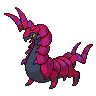

In [77]:
#prompt = "Turn this cat into a dog"
input_image = load_image("./scolipede.png")

input_image

In [82]:
negative_embed = torch.zeros_like(starting_embeds)
negative_embed.shape

torch.Size([1, 1, 1024])

In [83]:
combined_embeds = torch.cat([negative_embed, starting_embeds], dim=0)
combined_embeds.shape

torch.Size([2, 1, 1024])

In [84]:
image = pipe(prompt="", image=input_image, ip_adapter_image_embeds=[combined_embeds], strength=0.99, guidance_scale=7.5).images[0]

image

  0%|          | 0/49 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x1024 and 1280x768)